
<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
 <h2>Mentoría: Clasificación de Tumoresferas </h2>
</center>



<a name="exploratory_data_analysis"></a>
#### **Práctico de Análisis Exploratorio y Visualización**



### Descripción de los datos: 

Se tratan de datos procesados en el [Grupo de Materia Condensada](https://ri.conicet.gov.ar/handle/11336/102) (FaMAF-UNC, IFEG-CONICET) en colaboración con el Laboratorio de Células Madre del [IBYME-CONICET](https://www.ibyme.org.ar/laboratorios/49/celulas-madre) a partir de imágenes tomadas usando un microscopio óptico invertido común.


Para extraer la información estructurada a partir de las imágenes se hizo uso del programa Fiji, que es un paquete de procesamiento de imágenes, distribución muy completa del programa [ImageJ](https://www.medicinatv.com/profesional/reportajes/una-plataforma-abierta-revoluciona-el-procesamiento-de-imagenes-biomedicas-4596/), que es ampliamente utilizado para procesar
imágenes médicas. 

De acuerdo a la documentación del programa,
es posible contar y medir objetos si conocemos la escala en la cual se han
llevado a cabo dichas imágenes, en este caso, a cuántos $\mu$m equivale un
píxel.
Para llevar a cabo el procedimiento detallado en la [documentación](https://imagej.nih.gov/ij/docs/guide/146-30.html#sub:Analyze-Particles...),
es necesario contar con una imagen umbralizada. 

Se realizó este procedimiento en las 91 imágenes disponibles y se etiquetaron en *esferoides* 'si' y 'no' de acuerdo al criterio de un [experto](https://www.conicet.gov.ar/new_scp/detalle.php?id=43977&datos_academicos=yes), obteniendo 1018 datos.



Importamos las librerías necesarias:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#sns.set_context("talk")
# por si quieren ver los distintos formatos:
# https://datavizpyr.com/seaborn-set_context-to-adjust-size-of-plot-labels-and-lines/
# https://seaborn.pydata.org/generated/seaborn.set_context.html

import warnings

warnings.filterwarnings("ignore")

from scipy.stats import kurtosis, skew
import scipy.stats
import math

## Datos


Cargamos los datos de los experimentos realizados desde el día cero al séptimo. 


Ya se encuentran las etiquetas y el valor de las poblaciones celulares estimadas en cada esferoide.

In [2]:
try:
    fiji_datos = pd.read_csv("fiji_datos_0al7mo_labels.csv")
except FileNotFoundError:
    fiji_datos = pd.read_csv("http://www.ccll.com.ar/fiji_datos_0al7mo_labels.csv")

fiji_datos.head()

,labels,Area,X,Y,XM,YM,Perim.,BX,BY,Width,...,FeretY,FeretAngle,MinFeret,AR,Round,Solidity,Esferoide,dia,Diameter,n_diam
0,Esferas_BT474_dia_0_well_1_100X_1_blob_1,324.4440,1129.2718,102.2051,1129.2718,102.2051,67.3603,1118.8859,92.3913,21.0598,...,157,23.4287,19.7011,1.0653,0.9387,0.9500,si,0,20.95640,1.491357
1,Esferas_BT474_dia_0_well_1_100X_1_blob_2,497.5115,1517.5528,126.1022,1517.5528,126.1022,82.8004,1504.7554,113.4511,25.8152,...,192,16.1443,25.1289,1.0475,0.9546,0.9569,si,0,26.00200,2.848733
2,Esferas_BT474_dia_0_well_1_100X_1_blob_3,282.9078,1314.2815,126.0988,1314.2815,126.0988,62.1586,1304.3478,116.8478,19.7011,...,189,15.4222,18.3424,1.0395,0.9620,0.9519,si,0,19.38970,1.181258
3,Esferas_BT474_dia_0_well_1_100X_1_blob_5,500.7421,1189.2841,212.6155,1189.2841,212.6155,84.5571,1175.9511,200.4076,26.4946,...,309,174.1440,25.1359,1.0278,0.9730,0.9493,si,0,25.88475,2.810370
4,Esferas_BT474_dia_0_well_1_100X_1_blob_6,492.8964,1043.0782,247.7667,1043.0782,247.7667,82.0728,1030.5707,235.7337,25.1359,...,353,143.4270,24.4565,1.0186,0.9817,0.9643,si,0,25.33985,2.636596


#### Descripción de las columnas:

   * **labels** (*'nombre_id'*): etiqueta que indica la estructura segmentada seleccionada. 
   * **Area** (*'area'*): columna que indica el área de selección en $\mu$m$^2$.
   * **Perim.** (*'perimetro'*): Es la longitud  del límite exterior de la selección. 
   * **Width** (*'ancho'*) y **Height** (*'altura'*): Es el ancho y la altura del rectángulo mas pequeño que encierra la estructura seleccionada.
   * **Circ.** (*'circulalidad'*): Indica la *circularidad*. Se calcula como 4π × [Area]/[Perimeter]$^2$, que con un valor de 1.0 indica un círculo perfecto. A medida que se acerca a 0.0, indica una forma cada vez más alargada. 
   * Columnas del diámetro de Feret: 
       * **Feret** (*feret*): Indica la distancia más larga entre dos puntos a lo largo del límite de selección. 
       * **MinFeret** (*min_feret*): Indica la distancia mínima entre dos puntos a lo largo del límite de selección.
       * **FeretAngle**: Indica el ángulo del diámetro de Feret.
       * **FeretX** y **FeretY**: son las coordenadas iniciales del diámetro de Feret. 
       * **AR** (*razon_aspecto*): Indica la  razón de aspecto de la elipse ajustada de la estructura seleccionada, es decir, [Eje mayor]/[Eje menor].
       * **Round** (*redondez*): Se calcula como  (4 × [Area] )/ (π × [Major axis]^2) o como la inversa de **AR**. Tiene un rango entre 0 y 1, con 1 indicando un círculo perfecto.
       * **Solidity**: Se calcula como [Area]/[Convex area]. Se calcula el área convexa como el área de una banda elástica envuelta firmemente alrededor de los puntos que definen la selección.
       * **Esferoide** (*esferoide*): etiqueta que indica si la estructura seleccionada califica como esferoide o no
       * **dia**: etiqueta que indica el día en el cual fue realizada la fotografía de origen. 
       * **Diameter** (*diametro*): Se calculó como 0.5*(*Feret*+*MinFeret*)
       * **n_diam** (*poblacion_celular*)


**Modelo para la estimación de la población celular *n_diam*:**

*Se puede hacer una estimación de la cantidad de células en una tumoresfera a partir del volumen $V_1$ de una célula de diámetro $D_1$;*

*Si tenemos una célula, entonces $V_1 = \frac{\pi}{6} D_1^3$ pero si el esferoide tiene $n$ células, entonces tendremos un volumen $V_n = n V_1$ para un diámetro $D_n$ de manera que $V_n =  \frac{\pi}{6} D_n^3$.*

*Si conocemos el diámetro $D_1$ de la célula a un tiempo inicial y el diámetro $D_n$ a un tiempo posterior, reemplazando $V_n$ y $V_1$ podemos estimar la población celular $n$ como: $n  = \frac{V_n}{V_1}= \frac{D_n^3}{D_0^3}.$*






Como utilizamos las imágenes ya segmentadas y recortadas, las columnas *X*, *Y*, *XM*, *YM*, *BX*, *BY*, las coordenadas del diámetro de Feret (*FeretX* y *FeretY*) y el ángulo (*FeretAngle*) **¿suman información al análisis?**
 

Para mas información, pueden explorar la [documentación](https://imagej.nih.gov/ij/docs/guide/146-30.html#sub:Analyze-Particles...).


Pueden ver las imágenes crudas y las individuales (cada fila es una estructura) en la siguiente [carpeta compartida](https://drive.google.com/drive/folders/1aws02t4Z0wSrdbHsQ-cgBkwX8PKLU71c?usp=sharing).

# Análisis de los datos:

*   1) a) Explorar cuántos datos son, ¿cuáles son las columnas? Diferenciar entre categóricas y numéricas.
    
       b) De acuerdo a la descripción de las columnas, definir cuáles son las más importantes y descartar las columnas que no tienen mucha validez para el problema.

*   2) Cambiar el nombre de las columnas en inglés a castellano (están indicadas en paréntesis en la descripción).
*   3) Tratemos de responder alguna de las siguientes preguntas:
    * a) ¿Se trata de una muestra o población?
    * b) ¿Es más probable que sea esferoide a que no lo sea?

    * c) ¿La forma (área, circularidad, diámetro, redondez) influye en la clasificación de *Esferoide*? 
    
    * d) ¿Tales variables son independientes entre sí? 
    * e) ¿La probabilidad de que la redondez ('Round') sea mayor a 0.9 en los clasificados como *Esferoides* = **si** es mayor que los clasificados como *Esferoides* = **no**?. 

* 4) También se puede explorar la muestra por día:
    * a) ¿Cuántos datos hay por día? Hacer gráfico de frecuencias.

    * b) Explorar con diagramas de cajas al menos una columna (ej. Diameter, n_diam, pero pueden animarse a más). 

    * c) Discriminar la(s) columna(s) elegida(s) en *Esferoide* **si** y **no** y ver sus distribuciones. ¿Son distintas?. Describirlas (asimetría, kurtosis, etc..)

    * d) ¿Hay outliers? Hacer con el total y luego discriminando por *Esferoide'* **si** y **no**. ¿Qué pueden implicar biológicamente? Si los eliminan, ¿cuál sería la justificación?

     Si identifican un par, traten de determinar el *'nombre_id'* y las buscamos en las imágenes en la [carpeta compartida](https://drive.google.com/drive/folders/1aws02t4Z0wSrdbHsQ-cgBkwX8PKLU71c?usp=sharing).

    * e) La media de los esferoides=*no* al día 3 es igual que al día 5? Realizar Test de Hipótesis. 
   
    * f) Determinen el intervalo de confianza diario de tal(es) columna(s) para las clasificadas como *'Esferoide'*=**'si'**. Y exploren como utilizarlos como barras de error en el gráfico. 
  
    El intervalo de confianza está dado por $$[LI;LS]$$ donde

    $$ LI = \overline{x}-t_{n-1,1-\alpha/2}\frac{s}{\sqrt n}$$
    $$ LS = \overline{x}+t_{n-1,1-\alpha/2}\frac{s}{\sqrt n}$$

   siendo $s$ la desviación de la distribución y $n$ el tamaño de la muestra.
   Pueden calcular el t-valor en la siguiente [página](https://goodcalculators.com/student-t-value-calculator/) y explorar la librería [scipy.stats.t](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html) .



Interpretar lo que ven en los gráficos en términos generales. ¿Qué creen que sucedió a partir del día 6? 


* 5) ¿Qué otras preguntas se pueden o quisieran plantear? (las que puedan y quieran, las responden, sino planteenlas nomás y las charlamos, quizás se las puede responder con otras herramientas o simplemente son interesantes para tenerlas en cuenta y sería lindo tener otra clase de datos para responderlas.) 


Recordar que es importante como se comunican las respuestas, usar lo que van prendiendo a partir de cada punto y también guitarra ;).

Diseñar e implementar una comunicación a partir de algún ejercicio/s del entregable que les haya llamado la atención y que les parezca relevante en un archivo PDF o ppt.

---

## Ejercicio 1

### a) Exploración inicial: columnas

In [3]:
fiji_datos.shape

(1018, 24)

Como podemos ver, el data set consta de 1018 filas, en concordancia con el número de datos mencionado inicialmente, y 24 columnas. Estas son

In [4]:
fiji_datos.columns

Index(['labels', 'Area', 'X', 'Y', 'XM', 'YM', 'Perim.', 'BX', 'BY', 'Width',
       'Height', 'Circ.', 'Feret', 'FeretX', 'FeretY', 'FeretAngle',
       'MinFeret', 'AR', 'Round', 'Solidity', 'Esferoide', 'dia', 'Diameter',
       'n_diam'],
      dtype='object')

In [5]:
fiji_datos.dtypes

labels         object
Area          float64
X             float64
Y             float64
XM            float64
YM            float64
Perim.        float64
BX            float64
BY            float64
Width         float64
Height        float64
Circ.         float64
Feret         float64
FeretX          int64
FeretY          int64
FeretAngle    float64
MinFeret      float64
AR            float64
Round         float64
Solidity      float64
Esferoide      object
dia             int64
Diameter      float64
n_diam        float64
dtype: object

In [6]:
fiji_datos["labels"].unique()

array(['Esferas_BT474_dia_0_well_1_100X_1_blob_1',
       'Esferas_BT474_dia_0_well_1_100X_1_blob_2',
       'Esferas_BT474_dia_0_well_1_100X_1_blob_3', ...,
       'Esferas_BT474_dia_7_well_2_100X_5_blob_5',
       'Esferas_BT474_dia_7_well_2_100X_6_blob_3',
       'Esferas_BT474_dia_7_well_2_100X_6_blob_4'], dtype=object)

In [7]:
fiji_datos["Esferoide"].unique()

array(['si', 'no'], dtype=object)

Las columnas son todas numéricas, exepto por la que etiqueta los agregados y la que los clasifica según sean o no esferoides, siendo esta última una variable categórica. Ambas tienen strings como valores.

### b) Selección de columnas

Comenzamos eliminando las columnas X, Y, XM, YM, BX, BY que deben hacer referencia a posiciones absolutas en la imagen original, por lo que no tienen sentido en principio en la imágen recortada. Todo esto asumiendo que el medio no haya presentado ninguna inhomogeneidad (e.g., debida a difusión), caso en el que podría ser relevante.

En principio, pensaría que las columnas más importantes son `'Esferoide', 'dia', 'Diameter', 'n_diam'`.

In [8]:
selected_cols = [
    "labels",
    "Area",
    "Perim.",
    "Width",
    "Height",
    "Circ.",
    "Feret",
    "FeretX",
    "FeretY",
    "FeretAngle",
    "MinFeret",
    "AR",
    "Round",
    "Solidity",
    "Esferoide",
    "dia",
    "Diameter",
    "n_diam",
]

df = fiji_datos[selected_cols]
df.head()

,labels,Area,Perim.,Width,Height,Circ.,Feret,FeretX,FeretY,FeretAngle,MinFeret,AR,Round,Solidity,Esferoide,dia,Diameter,n_diam
0,Esferas_BT474_dia_0_well_1_100X_1_blob_1,324.4440,67.3603,21.0598,19.7011,0.8985,22.2117,1648,157,23.4287,19.7011,1.0653,0.9387,0.9500,si,0,20.95640,1.491357
1,Esferas_BT474_dia_0_well_1_100X_1_blob_2,497.5115,82.8004,25.8152,25.1359,0.9119,26.8751,2215,192,16.1443,25.1289,1.0475,0.9546,0.9569,si,0,26.00200,2.848733
2,Esferas_BT474_dia_0_well_1_100X_1_blob_3,282.9078,62.1586,19.7011,18.3424,0.9201,20.4370,1920,189,15.4222,18.3424,1.0395,0.9620,0.9519,si,0,19.38970,1.181258
3,Esferas_BT474_dia_0_well_1_100X_1_blob_5,500.7421,84.5571,26.4946,25.1359,0.8801,26.6336,1731,309,174.1440,25.1359,1.0278,0.9730,0.9493,si,0,25.88475,2.810370
4,Esferas_BT474_dia_0_well_1_100X_1_blob_6,492.8964,82.0728,25.1359,24.4565,0.9195,26.2232,1520,353,143.4270,24.4565,1.0186,0.9817,0.9643,si,0,25.33985,2.636596


In [9]:
df.columns

Index(['labels', 'Area', 'Perim.', 'Width', 'Height', 'Circ.', 'Feret',
       'FeretX', 'FeretY', 'FeretAngle', 'MinFeret', 'AR', 'Round', 'Solidity',
       'Esferoide', 'dia', 'Diameter', 'n_diam'],
      dtype='object')

## Ejercicio 2

In [10]:
translations_dict = {
    "labels": "nombre_id",
    "Area": "area",
    "Perim.": "perimetro",
    "Width": "ancho",
    "Height": "altura",
    "Circ.": "circulalidad",
    "Feret": "feret",
    "FeretX": "feret_x",
    "FeretY": "feret_y",
    "FeretAngle": "ang_feret",
    "MinFeret": "min_feret",
    "AR": "razon_aspecto",
    "Round": "redondez",
    "Solidity": "solidez",
    "Esferoide": "esferoide",
    "dia": "dia",
    "Diameter": "diametro",
    "n_diam": "poblacion_celular",
}

df.rename(columns=translations_dict, inplace=True)

In [11]:
df.columns

Index(['nombre_id', 'area', 'perimetro', 'ancho', 'altura', 'circulalidad',
       'feret', 'feret_x', 'feret_y', 'ang_feret', 'min_feret',
       'razon_aspecto', 'redondez', 'solidez', 'esferoide', 'dia', 'diametro',
       'poblacion_celular'],
      dtype='object')

In [12]:
df.head()

,nombre_id,area,perimetro,ancho,altura,circulalidad,feret,feret_x,feret_y,ang_feret,min_feret,razon_aspecto,redondez,solidez,esferoide,dia,diametro,poblacion_celular
0,Esferas_BT474_dia_0_well_1_100X_1_blob_1,324.4440,67.3603,21.0598,19.7011,0.8985,22.2117,1648,157,23.4287,19.7011,1.0653,0.9387,0.9500,si,0,20.95640,1.491357
1,Esferas_BT474_dia_0_well_1_100X_1_blob_2,497.5115,82.8004,25.8152,25.1359,0.9119,26.8751,2215,192,16.1443,25.1289,1.0475,0.9546,0.9569,si,0,26.00200,2.848733
2,Esferas_BT474_dia_0_well_1_100X_1_blob_3,282.9078,62.1586,19.7011,18.3424,0.9201,20.4370,1920,189,15.4222,18.3424,1.0395,0.9620,0.9519,si,0,19.38970,1.181258
3,Esferas_BT474_dia_0_well_1_100X_1_blob_5,500.7421,84.5571,26.4946,25.1359,0.8801,26.6336,1731,309,174.1440,25.1359,1.0278,0.9730,0.9493,si,0,25.88475,2.810370
4,Esferas_BT474_dia_0_well_1_100X_1_blob_6,492.8964,82.0728,25.1359,24.4565,0.9195,26.2232,1520,353,143.4270,24.4565,1.0186,0.9817,0.9643,si,0,25.33985,2.636596


## Ejercicio 3

### a) ¿Muestra o población?

En principio, es un problema de definición, pero como lo más razonable es que estemos interesados en inferir algo de las tumoresferas o los agregados multicelulares en general, definiríamos como nuestra población a todos los agregados multicelulares. Luego, de esta población, los agregados obtenidos en estos experimentos (presentes en nuestro data set) son una muestra.

### b) Esferoides sí vs no

Para saber si es más probable que sea o no esferoide, contamos los “sí” y “no” de la columna “esferoide”.

In [13]:
# chequeo que sólo hay esferoide si
#df.loc[df['esferoide'] == 'si']['esferoide'].unique()
num_esf_si = df.loc[df['esferoide'] == 'si'].shape[0]
num_esf_no = df.loc[df['esferoide'] == 'no'].shape[0]

print(f'Número de esferas si: {num_esf_si} \nNúmero de esferas no: {num_esf_no}\n')
print(f'Suma esferas sí y no: {num_esf_si + num_esf_no}\n')
print(f'Porcentaje de esferas sí: {num_esf_si/1018}\nPorcentaje de esferas no: {num_esf_no/1018}')

Número de esferas si: 522 
Número de esferas no: 496

Suma esferas sí y no: 1018

Porcentaje de esferas sí: 0.5127701375245579
Porcentaje de esferas no: 0.48722986247544203


Como hay ligeramente más esferas sí que no, es más probable que un agregado tomado al azar sea esferoide que que no lo sea. Si pudiéramos extrapolar a la población, diríamos que es más probable que se te formen esferoides en este tipo de experimentos, que que se formen agregados que no esferoides.

¿Hacer test de hipótesis para ver si $P($'esferoide' = 'sí'$)$ es significativamente distinta a 0.5?


## c) Relación entre la forma y el ser esferoide

¿La forma (área, circularidad, diámetro, redondez) influye en la clasificación de Esferoide? Para decidir esto, comencemos haciendo pair plots de las variables de forma, separando los datos según sean o no esferoides.

(Los `scatter` están buenos, pero se distingue mejor con `kde`. Con `scatter` da la impresión de que los datos son más separables.)

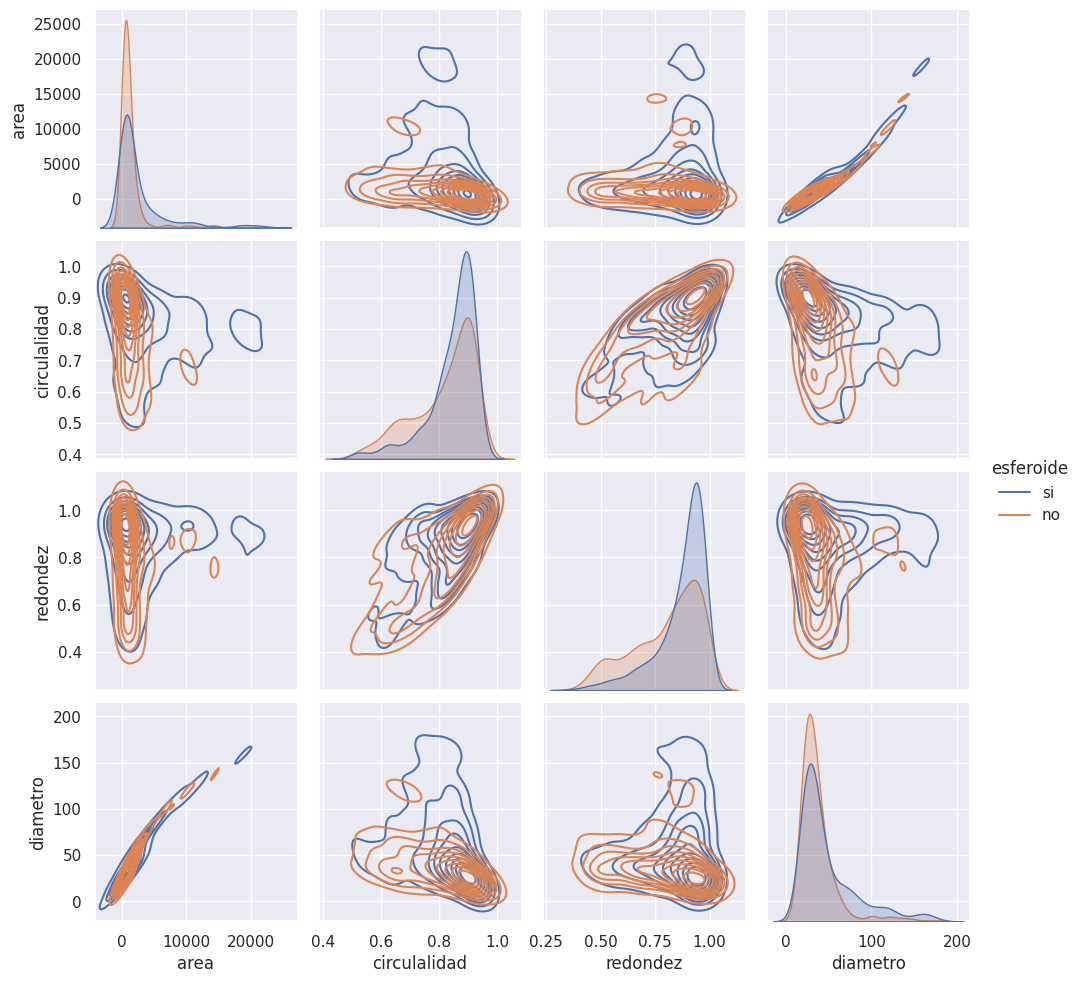

In [39]:
shape_cols = ['area',
              #'perimetro',
              #'ancho',
              #'altura',
              'circulalidad',
              #'feret',
              #'feret_x',
              #'feret_y',
              #'ang_feret',
              #'min_feret',
              #'razon_aspecto',
              'redondez',
              #'solidez',
              #'esferoide',
              #'dia',
              'diametro',
              #'poblacion_celular'
             ]

sns.pairplot(df,
            vars=shape_cols,
            hue='esferoide',
            kind='kde') # scatter
plt.show()

Empecemos analizando los histogramas (los gráficos sobre la diagonal). Todas las distribuciones parecen mostrar diferencias claras según se trate o no de esferoides. Recordemos que:
- El **sesgo** ([skewness](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html)) $\alpha_3$ de la distribución refleja la asimetría de la misma, siendo positivo cuando hay más área bajo la distribución a la derecha de la media.
- La **curtosis relativa** ([kurtosis](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html)) $\alpha_{4R}$ representa cuan “picuda” o “achatada” es la distribución, y es positiva para distribuciones más picudas que la distribución normal (y negativa cuando es más achatada que esta).

Veamos variable por variable:
1. Área: los esferoides tienen menor área, lo cual tiene sentido ya que los esferoides “no” son agregados que se han unido entre sí, por lo que esperamos que tengan más área. Además, la distribución de áreas para los esferoides parece tener una curtosis mayor.
2. Circularidad: los esferoides tienen mayor circularidad, lo cual es esperable porque al no haberse “pegoteado”, pueden mantener la forma esférica original (que esperamos por simetría).

#### Área

Hagamos un histograma de las áreas, separando según sean o no esferoides. Para que se visualice mejor la parte interesante de la distribución, ponemos un corte en las áreas en 15000, e incluimos la curva de la distribución.

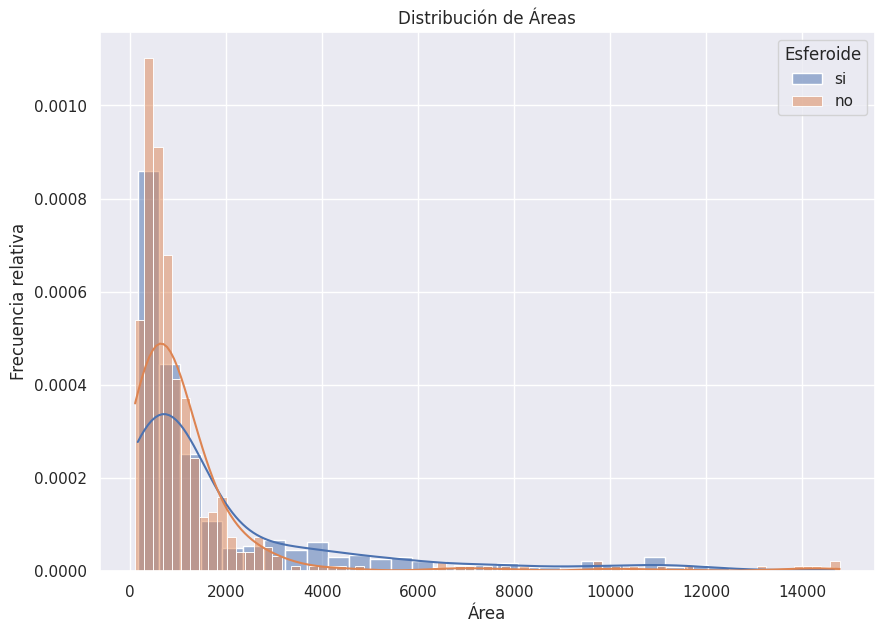

In [59]:
sns.set_theme(style="darkgrid")

si_no = df['esferoide'].unique()

df_area_limitted = df.loc[df['area']<15000]

plt.figure(figsize=(10, 7))
plt.title('Distribución de Áreas')

#print("\n")

for esferoide in si_no:
    subset = df_area_limitted[df_area_limitted['esferoide'] == esferoide]
    sns.histplot(subset['area'], kde=True, stat="density", label=esferoide)

plt.xlabel('Área')
plt.ylabel('Frecuencia relativa')
plt.legend(title='Esferoide')
plt.show()


Esferoide si:

	Mean: 2572.5680243295024
	Standard Deviation: 4076.1340198818107
	Skewness: 2.8661868313115613
	Kurtosis: 8.546850170958383

Esferoide no:

	Mean: 1292.4870788306453
	Standard Deviation: 2216.866767462206
	Skewness: 4.824964114558361
	Kurtosis: 26.52971073119558


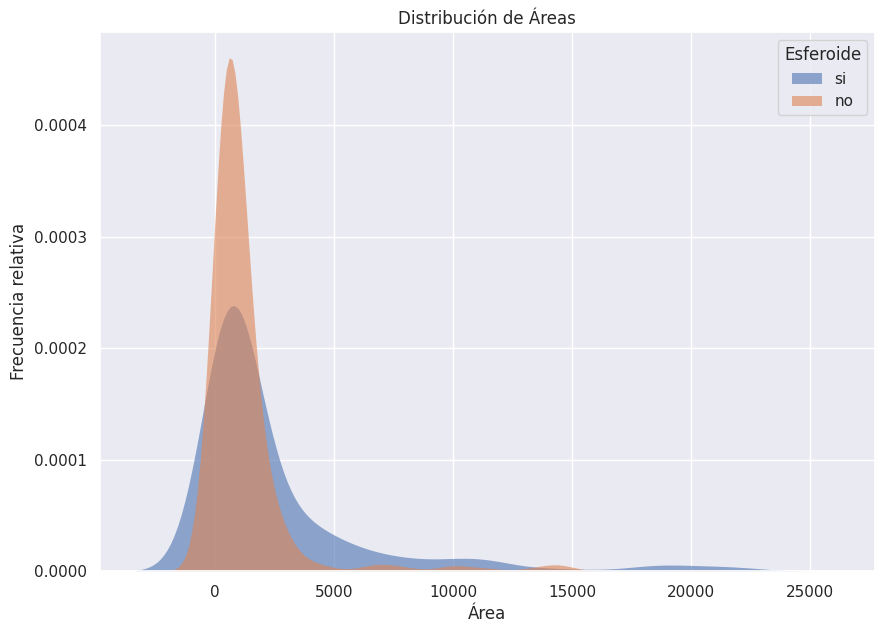

In [16]:
# Let's look more closely to the distributions and calculate their properties

sns.set_theme(style="darkgrid")

esferoides = df['esferoide'].unique()

plt.figure(figsize=(10, 7))
plt.title('Distribución de Áreas')

mean_sino = [0,0]
std_sino = [0,0]
skew_sino = [0,0]
kurt_sino =[0,0]

for i, esferoide in enumerate(esferoides):
    # we select the 'si' or 'no' value
    subset = df.loc[df['esferoide'] == esferoide]
    
    # we plot the distributions
    sns.kdeplot(data=subset, x="area", fill=True, common_norm=False, 
                palette="crest", alpha=.6, linewidth=0, label=esferoide)
    
    # Calculate mean, std, skewness and kurtosis
    mean_sino[i] = np.mean(subset['area'])
    std_sino[i] = np.std(subset['area'])
    skew_sino[i] = skew(subset['area'])
    kurt_sino[i] = kurtosis(subset['area'])
    
    # print the results
    print(f"\nEsferoide {esferoide}:\n")
    print(f"\tMean: {mean_sino[i]}")
    print(f"\tStandard Deviation: {std_sino[i]}")
    print(f"\tSkewness: {skew_sino[i]}")
    print(f"\tKurtosis: {kurt_sino[i]}")

plt.xlabel('Área')
plt.ylabel('Frecuencia relativa')
plt.legend(title='Esferoide')
plt.show()


Puede ser que los esferoides logren más área porque logran prosperar (crecer). Habría que separar por días y ver cómo cambia.

In [17]:
df['dia'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

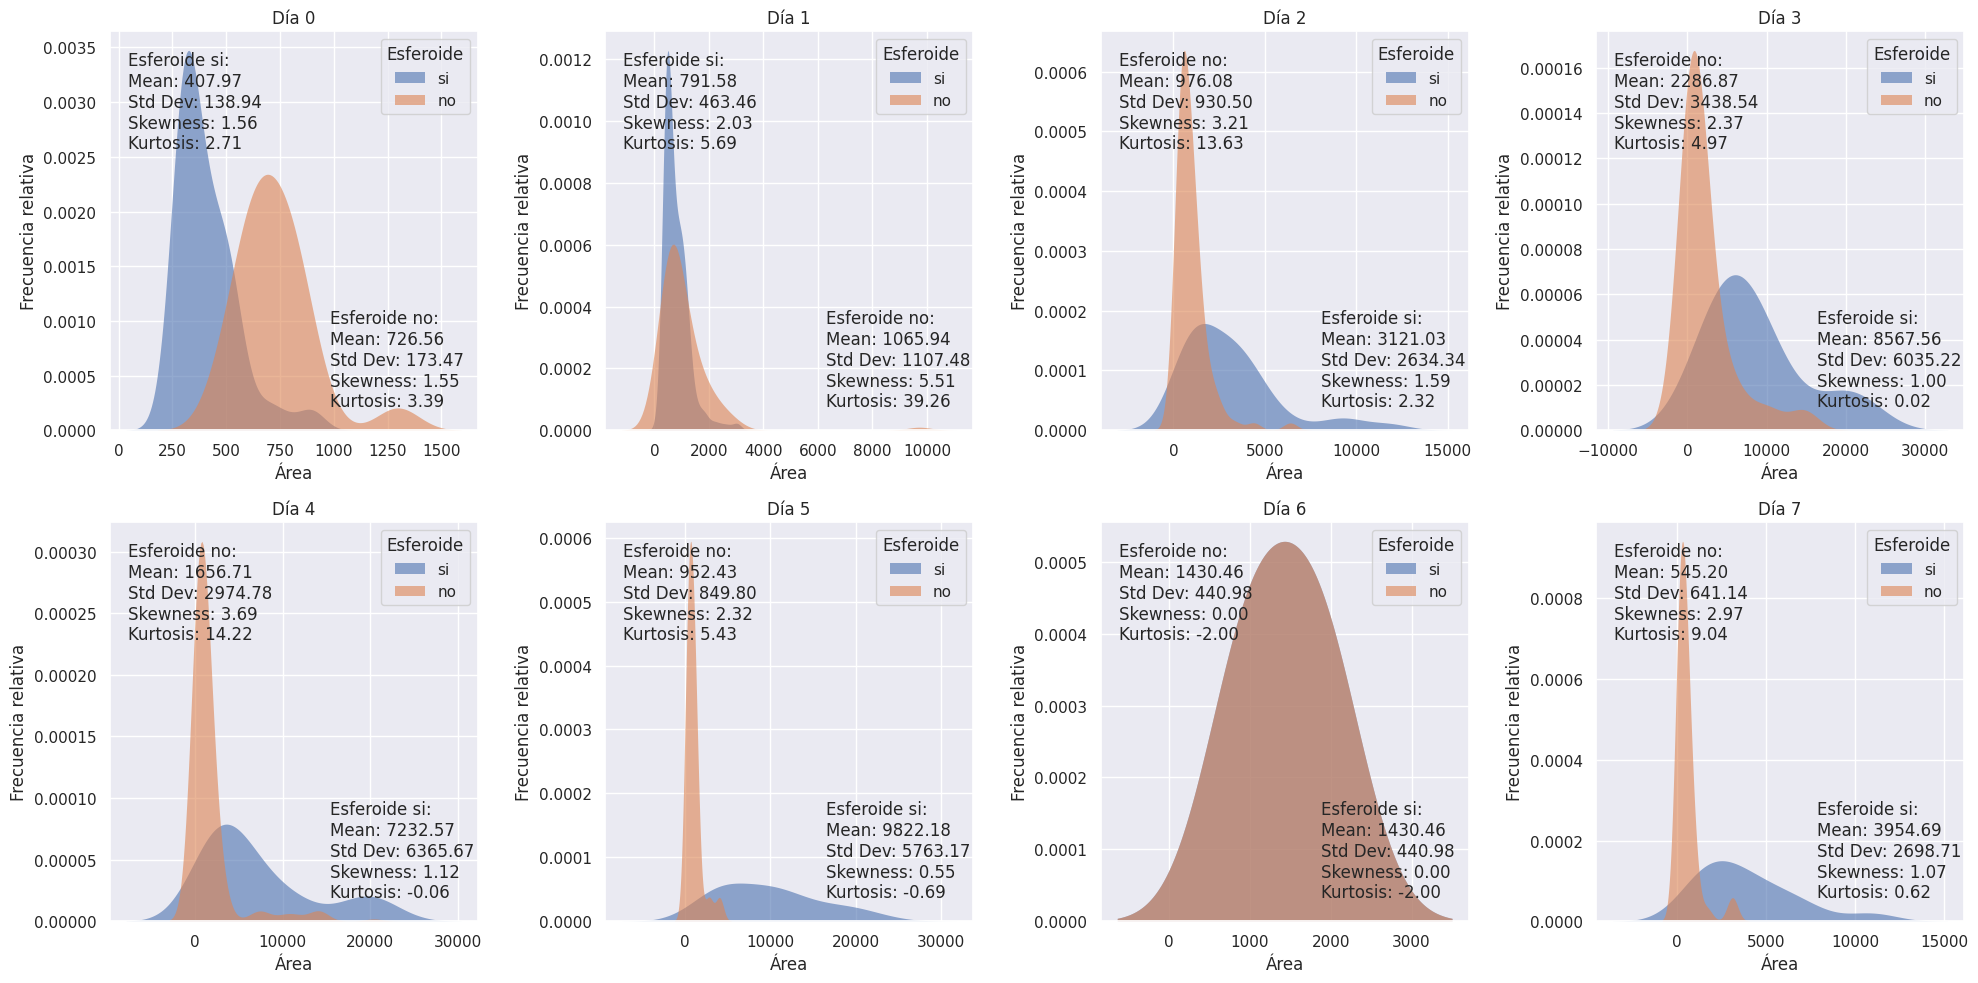

In [26]:
sns.set_theme(style="darkgrid")

esferoides = df['esferoide'].unique()
dias = df['dia'].unique()

fig, axs = plt.subplots(2, 4, figsize=(20, 10)) # Change the figsize values as needed
axs = axs.ravel()

# Upper left and lower right
text_positions = {'si': (0.6, 0.05), 'no': (0.05, 0.95)}  
vertical_alignments = {'si': 'bottom', 'no': 'top'}

# Exceptions for 'dia' values 0 and 1 (because of how distributions ended up)
text_positions_exceptions = {'si': (0.05, 0.95), 'no': (0.6, 0.05)} 
vertical_alignments_exceptions = {'si': 'top', 'no': 'bottom'}

for j, dia in enumerate(dias):
    mean_sino = [0,0]
    std_sino = [0,0]
    skew_sino = [0,0]
    kurt_sino =[0,0]
    
    for i, esferoide in enumerate(esferoides):
        # We select the 'si' or 'no' value and specific 'dia'
        subset = df.loc[(df['esferoide'] == esferoide) & (df['dia'] == dia)]
        
        # We plot the distributions
        sns.kdeplot(data=subset, x="area", fill=True, common_norm=False, 
                    palette="crest", alpha=.6, linewidth=0, label=esferoide, ax=axs[j])
        
        # Calculate mean, std, skewness and kurtosis
        mean_sino[i] = np.mean(subset['area'])
        std_sino[i] = np.std(subset['area'])
        skew_sino[i] = skew(subset['area'])
        kurt_sino[i] = kurtosis(subset['area'])
        
        # Select the positions based on 'dia'
        if dia in [0, 1]:
            text_position = text_positions_exceptions[esferoide]
            vertical_alignment = vertical_alignments_exceptions[esferoide]
        else:
            text_position = text_positions[esferoide]
            vertical_alignment = vertical_alignments[esferoide]
        
        # Annotate the results
        stats_text = f"Esferoide {esferoide}:\nMean: {mean_sino[i]:.2f}\nStd Dev: {std_sino[i]:.2f}\nSkewness: {skew_sino[i]:.2f}\nKurtosis: {kurt_sino[i]:.2f}"
        axs[j].text(text_position[0], text_position[1], stats_text, 
                    transform=axs[j].transAxes, verticalalignment=vertical_alignment)

    axs[j].set_xlabel('Área')
    axs[j].set_ylabel('Frecuencia relativa')
    axs[j].legend(title='Esferoide')
    axs[j].set_title(f'Día {dia}')

plt.tight_layout()
plt.show()


Y esto ahora sí tiene sentido. Uno podría interpretar (?) que a tiempos tempranos los esferoides son más pequeños que los no esferoides, pues estos últimos son agregados que se han unido. Pero a medida que el tiempo avanza, los esferoides logran prosperar más que los no esferoides. Esto puede verse observando las medias de las distrubuciones. Para el día 0, el área media de los esferoides es menor a la del resto. Para el día 1, este sigue siendo el caso, pero las áreas se parecen mucho más. A partir del día 2, los esferoides tienen una área media mayor al resto. Veamos este aspecto (por separado) en más detalle.

Desde ya, el día 6 va a ser un problema, porque las distribuciones se están solapando de manera perfecta y no tienen sesgo. Como mínimo debemos estar teniendo pocos datos, pero eso no explica que se solapen.

In [53]:
# Create an empty DataFrame to store the stats

stats_df = pd.DataFrame(columns=['dia', 'esferoide', 'mean', 'std', 'skewness', 'kurtosis'])

for dia in dias:
    for esferoide in esferoides:
        # Select the 'si' or 'no' value and specific 'dia'
        subset = df.loc[(df['esferoide'] == esferoide) & (df['dia'] == dia)]
        
        # Calculate mean, std, skewness and kurtosis
        mean = np.mean(subset['area'])
        std = np.std(subset['area'])
        skewness = skew(subset['area'])
        kurt = kurtosis(subset['area'])
        
        # Append the stats to the DataFrame
        stats_df = pd.concat([stats_df, pd.DataFrame([{'dia': dia, 
                                                      'esferoide': esferoide, 
                                                      'mean': mean, 
                                                      'std': std, 
                                                      'skewness': skewness, 
                                                      'kurtosis': kurt}], 
                                                     columns=['dia', 'esferoide', 'mean', 'std', 'skewness', 'kurtosis'])], 
                             ignore_index=True)

# show the stats_df DataFrame
stats_df.head()

,dia,esferoide,mean,std,skewness,kurtosis
0,0,si,407.971664,138.939120,1.564079,2.710872
1,0,no,726.560650,173.471251,1.547132,3.394319
2,1,si,791.584984,463.458069,2.032979,5.690728
3,1,no,1065.940546,1107.478672,5.513719,39.262927
4,2,si,3121.030984,2634.336308,1.585580,2.324441


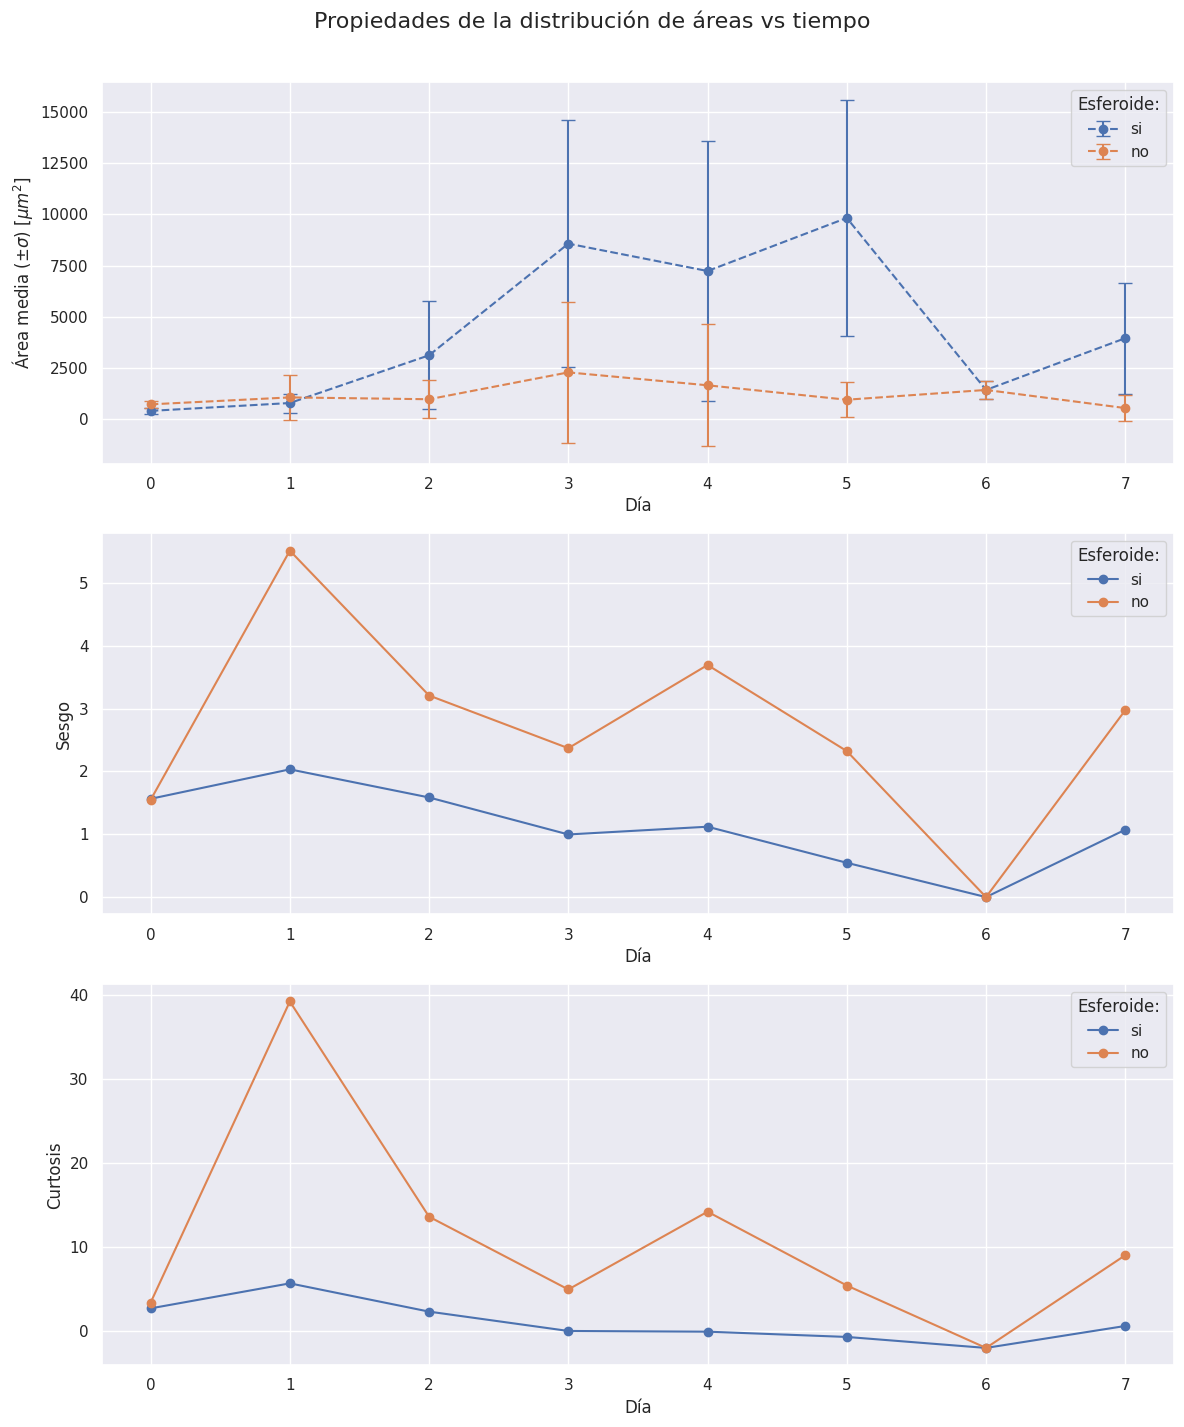

In [56]:
fig, axs = plt.subplots(3, 1, figsize=(12, 15))

# Create a list of the y variables and their corresponding labels
y_vars = [('mean', 'Área media ($\pm \sigma$) [$\mu m^2$]'), ('skewness', 'Sesgo'), ('kurtosis', 'Curtosis')]
  
for i, (y_var, y_label) in enumerate(y_vars):
    for esferoide in esferoides:
        subset = stats_df[stats_df['esferoide'] == esferoide]
        if y_var == 'mean':
            axs[i].errorbar(x=subset['dia'], y=subset[y_var], yerr=subset['std'], 
                            label=esferoide, fmt='o--', capsize=5)
        else:
            axs[i].plot(subset['dia'], subset[y_var], 'o-', label=esferoide)
        axs[i].set_ylabel(y_label)
        axs[i].set_xlabel('Día')  # Add x-label for each subplot
        axs[i].legend(title='Esferoide:')

fig.suptitle('Propiedades de la distribución de áreas vs tiempo', fontsize=16)  # Add a general title for the whole figure
plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust the layout to make room for the title
plt.show()


En el gráfico anterior se corrobora que el área media de los esferoides comienza siendo menor, pero luego sobrepasa a la del resto. La única excepción es el día 6, donde el problema parece ser que la muestra de agregados que se tomó (los agregados fotografiados) tiene un conteo bajo de esferoides.

In [37]:
esf_count_day_6 = df.loc[(df['esferoide'] == 'si') & (df['dia'] == 6)].shape[0]

print(f'Esferoides muestreados en el día 6: {esf_count_day_6}')

Esferoides muestreados en el día 6: 2


De todos modos, es raro que coincidan, veamos esto en más detalle.

In [38]:
df.loc[df['dia'] == 6]

,nombre_id,area,perimetro,ancho,altura,circulalidad,feret,feret_x,feret_y,ang_feret,min_feret,razon_aspecto,redondez,solidez,esferoide,dia,diametro,poblacion_celular
940,Esferas_BT474_dia_6_well_1_100X_11_blob_1,989.4849,119.0473,36.6848,37.3641,0.8774,38.2612,581,329,163.4956,34.3726,1.0725,0.9324,0.9593,si,6,36.3169,7.761717
941,Esferas_BT474_dia_6_well_1_100X_12_blob_1,1871.4371,162.8552,48.2337,48.2337,0.8867,52.4684,613,441,48.6745,47.7822,1.0654,0.9387,0.9758,si,6,50.1253,20.408095
942,Esferas_BT474_dia_6_well_1_100X_11_blob_1,989.4849,119.0473,36.6848,37.3641,0.8774,38.2612,581,329,163.4956,34.3726,1.0725,0.9324,0.9593,no,6,36.3169,7.761717
943,Esferas_BT474_dia_6_well_1_100X_12_blob_1,1871.4371,162.8552,48.2337,48.2337,0.8867,52.4684,613,441,48.6745,47.7822,1.0654,0.9387,0.9758,no,6,50.1253,20.408095


Notemos que los datos del día 6 coinciden porque los mismos 2 agregados están incluidos como esferoides “si” y “no”. Esto es lo que ocasionaba que las distribuciones se solapen y es, sin duda, un error en el data set. “`Esferas_BT474_dia_6_well_1_100X_11_blob_1`” es o no es un esferoide, y lo mismo para el “`Esferas_BT474_dia_6_well_1_100X_12_blob_1`”. En cualquier caso, aun pudiendo averiguar cómo es y corregirlo, tendríamos una categoría sin datos o tendríamos un dato por categoría, por lo que no nos va a quedar otra que desestimar los datos para el día 6.

Resumen:
- El área para los esferoides comienza siendo menor, pero eventualmente supera a la del resto.
- Si bien ambos grupos tienen sesgo positivo (las distribuciones son asimétricas, con más área a la derecha de la media), los esferoides tienen un sesgo menor al resto, que parece disminuir con el tiempo.
- En general, la curtosis de las distribuciones de área para los esferoides es menor a la del resto y cae con el tiempo, indicando que las distribuciones de áreas son más “achatadas” para los esferoides que para el resto.
- Los datos del día 6 son problemáticos

Algo llamativo, es que durante los primeros 5 días, el área de los esferoides parece tender a aumentar (algo que esperamos si estos están creciendo), pero este trend se corta en los últimos dos días. Si bien podemos esestimar los datos del día 6, los del día 7 no son pocos.

In [58]:
esf_count_day_7 = df.loc[(df['esferoide'] == 'si') & (df['dia'] == 7)].shape[0]

print(f'Esferoides muestreados en el día 7: {esf_count_day_7}')

Esferoides muestreados en el día 7: 29


---

En vez de repetir todo este análisis para las otras 3 variables, podría tratar de elegir algún par de “representantes”: variables que estén poco correlacionadas entre sí, pero muy correlacionadas con el resto, para hacer un plot de densidad en 2D y tratar de identificar grupos.

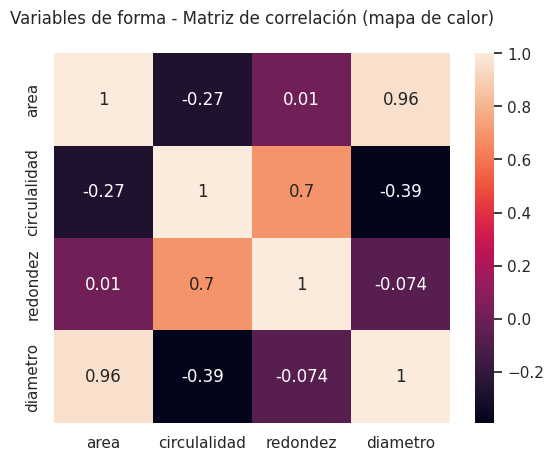

In [66]:
df_corr = df[shape_cols].dropna().corr()
sns.heatmap(df_corr, annot=True)
plt.title('Variables de forma - Matriz de correlación (mapa de calor)\n')
plt.show()

Estas cuatro variables se pueden dividir en dos grupos:
- Indicadoras de tamaño: área y diámetro
- Indicadoras de esfericidad: circularidad y redondez

De tamaño nos quedamos con área, ya que es la más independiente a las del otro grupo (por la definición de diámetro y los valores de correlación del gráfico anterior). De esfericidad, no creo que quedarnos con una sola sea demasiado robusto, pero aprovechando que ambas variables pertenecen al $[0,1]$, valiendo 1 para un círculo, podemos crear una variable combinada

$$round\_circ = \alpha_1 circularidad + \alpha_2 redondez$$

donde $\alpha_1+\alpha_2=1$ y $\alpha_i>\alpha_j$ indica que se le da más peso al criterio $i$ que al $j$. De este modo, para que una figura tenga $round\_circ = 1$, debe tener ambas métricas iguales a 1. Como en principio no tenemos argumentos para justificar una asimetría, tomamos $\alpha_1=\alpha_2$ y obtenemos $$round\_circ = \frac{circularidad + redondez}{2}$$

Calculemos esta nueva columna y hagamos el mismo análisis que para el área, y luego el análisis con ambas.